# Obtaining  Electrophysiology Data from the AllenSDK
 
The [Visual Coding - Neuropixels dataset from the Allen Institute of Brain Sciences](https://portal.brain-map.org/explore/circuits/visual-coding-neuropixels) records spiking activity in the visual system of the mouse brain. At the time of writing, this dataset contains a total of 58 experiment sessions from Neuropixels probes in the cortex, hippocampus, and thalamus. There are three different trangenic mouse lines used in the experiments alongside the wild-type mice, which mark three different inhibitory cell types. The stimuli presented in this dataset range from natural scenes to drifting gratings. 

In this chapter you will learn how to download and sort through the Neuropixels dataset. Once you learn the basics, you will learn how to perform possible analyses to explain the neural activity within, as well as how to use optogenetics to identify different cell types within the data. 

This section will teach you how to interact with the Allen Institute Neuropixels dataset, specifically how to download experimental sessions, return processed data, and subset your data to contain only brain regions you are interested in. 

First things first, let's make sure you have the AllenSDK installed. See the [Allen Institute website](https://alleninstitute.github.io/AllenSDK/install.html) for information on installing it, otherwise, the cell below will do it for you.

In [20]:
# This will ensure that the AllenSDK is installed.
# If not, it will install it for you.
try:
    import allensdk
    if allensdk.__version__ == '2.11.2':
        print('allensdk already installed.')
    else:
        print('incompatible version of allensdk installed')
except ImportError as e:
    !pip install allensdk

allensdk already installed.


We will first need to import the `EcephysProjectCache` from the Allen SDK and create an instance of the class. The class is used to download the metadata and data for all sessions in the Neuropixels dataset. For the full list of methods, please visit the `allensdk.brain_observatory.ecephys.ecephys_project_cache` module documentation on the <a href = 'https://allensdk.readthedocs.io/en/v1.7.1/allensdk.brain_observatory.ecephys.ecephys_project_cache.html'>Allen SDK website</a>. We'll create an instance of `EcephysProjectCache` with a larger `timeout` value to ensure enough time is allowed for our session file to download below. 

Below we will execute `get_session_table()` on our `EcephysProjectCache` object which will return a dataframe with metadata on each session.

In [21]:
# # Import packages necessary to plot behavior
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

# Import allensdkd brain observatory packages
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_project_api import EcephysProjectWarehouseApi
from allensdk.brain_observatory.ecephys.ecephys_project_api.rma_engine import RmaEngine
import allensdk.brain_observatory.ecephys.visualization as ecvis

# Assign where data will be stored
manifest_path = 'manifest.json' 

# Create the EcephysProjectCache object
cache = EcephysProjectCache(manifest=manifest_path,
                            fetch_api=EcephysProjectWarehouseApi(RmaEngine(scheme="http",host="api.brain-map.org",timeout= 50 * 60)))    

# Return all sessions available in this dataset
sessions = cache.get_session_table()
print('Total number of sessions: ' + str(len(sessions)))
sessions.head()

Total number of sessions: 58


published_at  specimen_id           session_type  \
id                                                                    
715093703  2019-10-03T00:00:00Z    699733581  brain_observatory_1.1   
719161530  2019-10-03T00:00:00Z    703279284  brain_observatory_1.1   
721123822  2019-10-03T00:00:00Z    707296982  brain_observatory_1.1   
732592105  2019-10-03T00:00:00Z    717038288  brain_observatory_1.1   
737581020  2019-10-03T00:00:00Z    718643567  brain_observatory_1.1   

           age_in_days sex                                    full_genotype  \
id                                                                            
715093703        118.0   M    Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
719161530        122.0   M    Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
721123822        125.0   M  Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
732592105        100.0   M                                            wt/wt   
737581020        108.0   M                                            wt/wt   

           unit_count  channel_count  probe_count  \
id                                                  
715093703         884           2219            6   
719161530         755           2214            6   
721123822         444           2229            6   
732592105         824           1847            5   
737581020         568           2218            6   

                                  ecephys_structure_acronyms  
id                                                            
715093703  [CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ...  
719161530  [TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N...  
721123822  [MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ...  
732592105       [grey, VISpm, nan, VISp, VISl, VISal, VISrl]  
737581020      [grey, VISmma, nan, VISpm, VISp, VISl, VISrl]

A few columns that we may want to pay attention to for future analysis are the `full_genotype`, `unit_count`, and `ecephys_structure_acronyms`. 

In this dataset, a `unit` referes to an individual neuron that was recorded in the session. The `unit_count` refers to the total number of neurons recorded in a particular sesssion. As mentioned in the chapter introduction, three different genotypes of mice were used alongside the wildtype mice for these experiments. You can find the genotype under `full_genotype`. Lastly, you can find what structures the data in a session was collected from under `ecephys_structure_acronyms`.

Below we will return the following information on our sessions: 
- how many sessions per genotype
- the average number of units recorded per session
- what brain structures were used in our sessions

In [22]:
genotypes = sessions['full_genotype'].value_counts()
avg_units = sessions['unit_count'].mean()

brain_areas = []

for idx,structure in sessions.iterrows():
    for i in structure['ecephys_structure_acronyms']:
        if i not in brain_areas:
            brain_areas.append(i)
        else:
            continue

print('Genotype Count:')
print(genotypes)

print('\nAverage Units:',avg_units)

print('\nAll brain areas:')
print(brain_areas)

Genotype Count:
wt/wt                                              30
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt      12
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt       8
Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt     8
Name: full_genotype, dtype: int64

Average Units: 689.8275862068965

All brain areas:
['CA1', 'VISrl', nan, 'PO', 'LP', 'LGd', 'CA3', 'DG', 'VISl', 'PoT', 'VISp', 'grey', 'VISpm', 'APN', 'MB', 'VISam', 'TH', 'Eth', 'POL', 'NOT', 'SUB', 'VL', 'CA2', 'VPM', 'VISal', 'SCig', 'PPT', 'VIS', 'ProS', 'LGv', 'HPF', 'VISmma', 'PP', 'PIL', 'MGv', 'VPL', 'IGL', 'SGN', 'IntG', 'LD', 'MGm', 'MGd', 'POST', 'MRN', 'VISli', 'OP', 'ZI', 'VISmmp', 'PF', 'LT', 'RPF', 'PRE', 'SCiw', 'CP', 'COAa', 'RT', 'SCop', 'SCsg', 'SCzo', 'COApm', 'OLF', 'BMAa']


Let's say we only want sessions where the data has recordings from primary visual cortex (VISp). We can do the following to create a session list that we want.

In [23]:
session_list = []

for idx,structure_list in enumerate(sessions['ecephys_structure_acronyms']):
    if 'VISp' in structure_list:
        session_list.append(sessions.index[idx])   
        
print('There are '+str(len(session_list))+' sessions that meet this criteria:')
print(session_list)

There are 56 sessions that meet this criteria:
[715093703, 719161530, 721123822, 732592105, 737581020, 739448407, 742951821, 743475441, 744228101, 746083955, 750332458, 750749662, 751348571, 754312389, 754829445, 755434585, 756029989, 757216464, 757970808, 758798717, 759883607, 760345702, 760693773, 761418226, 762120172, 762602078, 763673393, 766640955, 767871931, 768515987, 771160300, 771990200, 773418906, 774875821, 778240327, 778998620, 779839471, 781842082, 786091066, 787025148, 789848216, 791319847, 793224716, 794812542, 797828357, 798911424, 799864342, 816200189, 821695405, 829720705, 831882777, 835479236, 839068429, 839557629, 840012044, 847657808]


## Downloading a Single Session & the Structure of Session Files

Now, we can use the session list to get the data we need. Unfortunately, we can only extract one experiment at a time, so if you want to do this for multiple experiments, you'll need to loop over the `get_session_data` method for your entire session_list. For example, your workflow might be:

1. Extract one session.
2. Look for units recorded from your brain region of interest in that session.
3. Extract whatever metric you're interested in (e.g., firing rate).
4. Append those values to a list of firing rates.
5. Loop back around to the next session.

The `get_session_data` downloads the `NWB` data file of our experiment session and returns a session object that contains data and metadata for a single session. For a full list of methods and attributes for an ecephys session object, please visit the <a href = 'https://allensdk.readthedocs.io/en/v1.7.1/allensdk.brain_observatory.ecephys.ecephys_session.html'> Allen SDK session module documentation</a>. Here, we'll just take one session as an example.

**Note**: The session files are very large files that will take some time to download depending on your connection speed. It is important that you do not stop the download as the cell is running because this will truncate the file and you will not be able to work with the data.

In [33]:
# Download our single session data 
session = cache.get_session_data(session_list[1])
print('Session downloaded.')

Session downloaded.


## Obtaining Single Units

Now that we have downloaded the single session file, we can begin to explore our `EcephysSession` object. The `units` property of our session object returns a dataframe that contains the recorded activity of sorted neurons from a mouse brain. There are many metrics stored within `units` that can be used in your potential analyses. Some key metrics include:

- **firing rate**: mean spike rate during the entire session
- **presence ratio**: fraction of session when spikes are present
- **ISI violations**: rate of refractory period violations
- **peak_channel_id**: channel in which peak-to-trough amplitutde is maximized
- **d'**: classification accuracy based on LDA
- **SNR**: signal to noise ratio
- **Maximum drift**: Maximum change in spike depth during recording
- **Cumulative drift**: Cumulative change in spike depth during recording

For a full list of methods and attributes that can be called on an `EcephysSession` object, please review the original documentation for the <a href = 'https://allensdk.readthedocs.io/en/v1.7.1/allensdk.brain_observatory.ecephys.ecephys_session.html'> ecephys_session module</a>.

In [26]:
# Return units dataframe
units_df = session.units
units_df.head()

waveform_duration  cluster_id  peak_channel_id  cumulative_drift  \
unit_id                                                                       
950916730           0.315913           0        850252273            421.99   
950916822           0.233501           7        850252319            294.57   
950916845           0.192295           9        850252323            270.88   
950916856           0.233501          10        850252325            219.19   
950916892           0.343384          13        850252329            558.87   

           amplitude_cutoff       snr  waveform_recovery_slope  \
unit_id                                                          
950916730          0.010911  2.408535                -0.072013   
950916822          0.000025  3.769478                -0.212549   
950916845          0.023245  3.087942                -0.216281   
950916856          0.011552  2.743504                -0.087931   
950916892          0.029890  2.428990                -0.005812   

           isolation_distance  nn_miss_rate  silhouette_score  ...  \
unit_id                                                        ...   
950916730          115.066739      0.001010               NaN  ...   
950916822          160.983322      0.000000          0.115187  ...   
950916845           77.035531      0.002380          0.170339  ...   
950916856          291.708582      0.047256          0.141643  ...   
950916892           41.639547      0.000338          0.180152  ...   

           ecephys_structure_id  ecephys_structure_acronym  \
unit_id                                                      
950916730                 215.0                        APN   
950916822                 215.0                        APN   
950916845                 215.0                        APN   
950916856                 215.0                        APN   
950916892                 215.0                        APN   

           anterior_posterior_ccf_coordinate  dorsal_ventral_ccf_coordinate  \
unit_id                                                                       
950916730                             8369.0                         3658.0   
950916822                             8288.0                         3464.0   
950916845                             8281.0                         3448.0   
950916856                             8277.0                         3440.0   
950916892                             8270.0                         3424.0   

           left_right_ccf_coordinate  probe_description  \
unit_id                                                   
950916730                     6985.0             probeA   
950916822                     7039.0             probeA   
950916845                     7044.0             probeA   
950916856                     7046.0             probeA   
950916892                     7051.0             probeA   

                          location  probe_sampling_rate  \
unit_id                                                   
950916730  See electrode locations         29999.967418   
950916822  See electrode locations         29999.967418   
950916845  See electrode locations         29999.967418   
950916856  See electrode locations         29999.967418   
950916892  See electrode locations         29999.967418   

           probe_lfp_sampling_rate  probe_has_lfp_data  
unit_id                                                 
950916730              1249.998642                True  
950916822              1249.998642                True  
950916845              1249.998642                True  
950916856              1249.998642                True  
950916892              1249.998642                True  

[5 rows x 89 columns]

To ensure that the recordings we use in our analysis are all reliable and of good quality, we will filter the data according to the signal-to-noise ratio (`snr`) and the `ISI_Violations` of our neurons. Below we will plot the distributions of both.

In [27]:
fig,ax = plt.subplots(1,2,figsize=(10,3))

# Signal to noise distribution
ax[0].hist(units_df['snr'], bins=30)
ax[0].set_xlabel('Signal to Noise Ratio')
ax[0].set_ylabel('Frequency')

# ISI Violations
ax[1].hist(units_df['isi_violations'], bins=30)
ax[1].set_xlabel('Rate of Refractory Period Violations')
ax[1].set_ylabel('Frequency')

plt.show()

For the purposes of this tutorial, we will focus on units with `snr` values greater than 2 and `ISI_violation` values less than 0.1.

In [30]:
# Create dataframe from units that fit criteria
good_snr = units_df[units_df['snr']>2]
good_units_df = good_snr[good_snr['isi_violations']<0.1]

print('Number of units with good SNR and low ISI:',len(good_units_df))
good_units_df.head()

Number of units with good SNR and low ISI: 488


waveform_duration  cluster_id  peak_channel_id  cumulative_drift  \
unit_id                                                                       
950916730           0.315913           0        850252273            421.99   
950916822           0.233501           7        850252319            294.57   
950916856           0.233501          10        850252325            219.19   
950917034           0.467002          24        850252351            154.34   
950916996           0.192295          21        850252349            184.14   

           amplitude_cutoff       snr  waveform_recovery_slope  \
unit_id                                                          
950916730          0.010911  2.408535                -0.072013   
950916822          0.000025  3.769478                -0.212549   
950916856          0.011552  2.743504                -0.087931   
950917034          0.003052  2.084643                -0.059217   
950916996          0.003787  2.805553                -0.221815   

           isolation_distance  nn_miss_rate  silhouette_score  ...  \
unit_id                                                        ...   
950916730          115.066739      0.001010               NaN  ...   
950916822          160.983322      0.000000          0.115187  ...   
950916856          291.708582      0.047256          0.141643  ...   
950917034          179.310426      0.013169          0.102770  ...   
950916996           68.033790      0.003977          0.054381  ...   

           ecephys_structure_id  ecephys_structure_acronym  \
unit_id                                                      
950916730                 215.0                        APN   
950916822                 215.0                        APN   
950916856                 215.0                        APN   
950917034                 215.0                        APN   
950916996                 215.0                        APN   

           anterior_posterior_ccf_coordinate  dorsal_ventral_ccf_coordinate  \
unit_id                                                                       
950916730                             8369.0                         3658.0   
950916822                             8288.0                         3464.0   
950916856                             8277.0                         3440.0   
950917034                             8229.0                         3331.0   
950916996                             8232.0                         3339.0   

           left_right_ccf_coordinate  probe_description  \
unit_id                                                   
950916730                     6985.0             probeA   
950916822                     7039.0             probeA   
950916856                     7046.0             probeA   
950917034                     7079.0             probeA   
950916996                     7077.0             probeA   

                          location  probe_sampling_rate  \
unit_id                                                   
950916730  See electrode locations         29999.967418   
950916822  See electrode locations         29999.967418   
950916856  See electrode locations         29999.967418   
950917034  See electrode locations         29999.967418   
950916996  See electrode locations         29999.967418   

           probe_lfp_sampling_rate  probe_has_lfp_data  
unit_id                                                 
950916730              1249.998642                True  
950916822              1249.998642                True  
950916856              1249.998642                True  
950917034              1249.998642                True  
950916996              1249.998642                True  

[5 rows x 89 columns]

## Obtaining Single Action Potential Waveforms 

Each session contains a dictionary of mean waveforms for all the units recorded in that session. They are stored inside a xarray DataArray where the `unit_id` are mapped to the mean spike waveform values. The dimensions of the DataArrays are `channel` and `time` which are recorded in microvolts and seconds, respectivley. For more information on `xarray.DataArray`, please visit the <a href = 'http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html'> xarray original documentation</a>.

To access the mean spike waveforms for all units in a session, use the attribute `mean_waveforms` on your `EcephysSession` object. 

In [29]:
all_mean_waveforms = session.mean_waveforms
print('Total number of waveforms:',len(all_mean_waveforms))

Total number of waveforms: 755


We can plot the mean waveforms of our units with the method `plot_mean_waveforms` from the ecephys visualization package. The method uses the `mean_waveforms` dictionary, `unit_id`'s, and `peak_channel_id`'s as arguments. For more information on this method, visit the `allensdk.brain_observatory.ecephys.visualization` package documentation on the <a href = 'https://allensdk.readthedocs.io/en/latest/allensdk.brain_observatory.ecephys.visualization.html'> Allen Brain Atlas website</a>.

Below we will compare mean waveforms from units of different brain areas. We will be looking at one wavefrom from the `CA1`, `LP`, `DG`, `VISp`. We first need to create a list of unit_id's for the units we are interested in. 

In [31]:
# Assign Unit IDs of different brain areas of interest
CA1_unit_ids = good_units_df[good_units_df['ecephys_structure_acronym'] == 'CA1'].index
LP_unit_ids = good_units_df[good_units_df['ecephys_structure_acronym'] == 'LP'].index
DG_unit_ids = good_units_df[good_units_df['ecephys_structure_acronym'] == 'DG'].index
VISp_unit_ids = good_units_df[good_units_df['ecephys_structure_acronym'] == 'VISp'].index

# Return first entry of our brain areas of interst
first_CA1_units_ids = CA1_unit_ids[0]
first_LP_units_ids = LP_unit_ids[0]
first_DG_units_ids = DG_unit_ids[0]
first_VISp_units_ids = VISp_unit_ids[0]
uoi_ids = [first_CA1_units_ids, first_LP_units_ids, first_DG_units_ids, first_VISp_units_ids]

# Return dataframe
uoi_df = good_units_df.loc[uoi_ids]

uoi_df

waveform_duration  cluster_id  peak_channel_id  cumulative_drift  \
unit_id                                                                       
950918424           0.288442         124        850252701            138.64   
950924138           0.302178         221        850249435            132.03   
950918182           0.315913         105        850252619            112.89   
950934565           0.879062         336        850251321            139.52   

           amplitude_cutoff       snr  waveform_recovery_slope  \
unit_id                                                          
950918424          0.020835  2.185120                -0.039858   
950924138          0.000049  4.994113                -0.187781   
950918182          0.001606  2.447300                -0.087164   
950934565          0.000468  2.959099                -0.025951   

           isolation_distance  nn_miss_rate  silhouette_score  ...  \
unit_id                                                        ...   
950918424           90.797157      0.001406          0.102849  ...   
950924138          124.487692      0.000000          0.218848  ...   
950918182           75.802888      0.009311          0.044917  ...   
950934565           66.252958      0.000239          0.171097  ...   

           ecephys_structure_id  ecephys_structure_acronym  \
unit_id                                                      
950918424                 382.0                        CA1   
950924138                 218.0                         LP   
950918182                 726.0                         DG   
950934565                 385.0                       VISp   

           anterior_posterior_ccf_coordinate  dorsal_ventral_ccf_coordinate  \
unit_id                                                                       
950918424                             7767.0                         1620.0   
950924138                             7918.0                         2983.0   
950918182                             7856.0                         2095.0   
950934565                             8451.0                         1184.0   

           left_right_ccf_coordinate  probe_description  \
unit_id                                                   
950918424                     7511.0             probeA   
950924138                     7322.0             probeB   
950918182                     7339.0             probeA   
950934565                     7704.0             probeC   

                          location  probe_sampling_rate  \
unit_id                                                   
950918424  See electrode locations         29999.967418   
950924138  See electrode locations         29999.918880   
950918182  See electrode locations         29999.967418   
950934565  See electrode locations         29999.997521   

           probe_lfp_sampling_rate  probe_has_lfp_data  
unit_id                                                 
950918424              1249.998642                True  
950924138              1249.996620                True  
950918182              1249.998642                True  
950934565              1249.999897                True  

[4 rows x 89 columns]

Using the `unit_ids`, we can create our own dictionary that maps our units of interest to their `mean_waveforms` array.

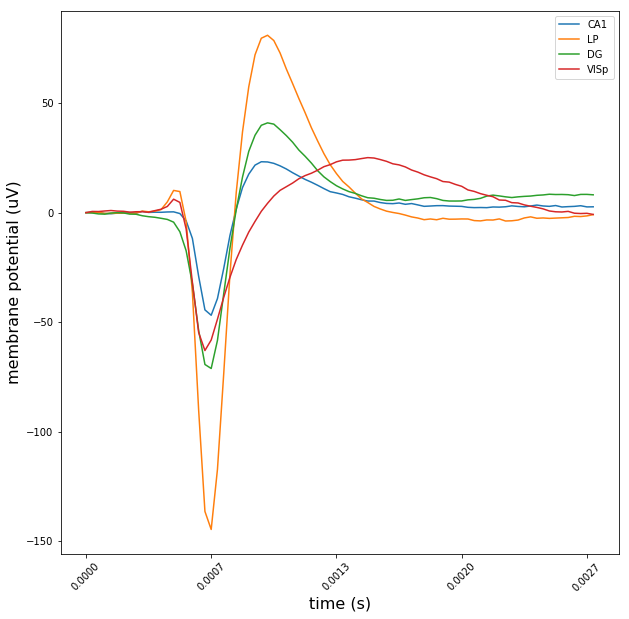

In [32]:
# Create dictionary of waveforms that only include units of interest
waveforms_oi = {}
for ids in uoi_ids:
    waveforms_oi[ids] = all_mean_waveforms[ids]

# Create dictionary of peak channels that only include units of interest
peak_channels_oi = {}
for ids in uoi_ids:
    peak_channels_oi[ids] = good_units_df.loc[ids, 'peak_channel_id']

# Plot mean waveforms
ecvis.plot_mean_waveforms(waveforms_oi, uoi_ids, peak_channels_oi)

legend_list = list(uoi_df['ecephys_structure_acronym'] )
plt.legend(legend_list)
plt.show()

### Additional Resources

* [Allen Institute Tutorial Notebook](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_session.html)